# Seeds clustering

We'll be working with a real data set about seeds, from UCI repository: https://archive.ics.uci.edu/ml/datasets/seeds.

The examined group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each, randomly selected for 
the experiment. High quality visualization of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin. 

The data set can be used for the tasks of classification and cluster analysis.


Attribute Information:

To construct the data, seven geometric parameters of wheat kernels were measured: 
1. area A, 
2. perimeter P, 
3. compactness C = 4*pi*A/P^2, 
4. length of kernel, 
5. width of kernel, 
6. asymmetry coefficient 
7. length of kernel groove. 
All of these parameters were real-valued continuous.

Let's see if we can cluster them in to 3 groups with K-means!

In [1]:
# import findspark
# findspark.init('/home/vboxuser/spark-3.3.1-bin-hadoop3/')

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('seeds').getOrCreate()

In [ ]:
seeds_data_raw = spark.read.csv('seeds_dataset.csv', inferSchema=True, header=True)

In [4]:
seeds_data_raw.printSchema()
seeds_data_raw.show(3)

root
 |-- area: double (nullable = true)
 |-- perimeter: double (nullable = true)
 |-- compactness: double (nullable = true)
 |-- length_of_kernel: double (nullable = true)
 |-- width_of_kernel: double (nullable = true)
 |-- asymmetry_coefficient: double (nullable = true)
 |-- length_of_groove: double (nullable = true)

+-----+---------+-----------+-----------------+------------------+---------------------+----------------+
| area|perimeter|compactness| length_of_kernel|   width_of_kernel|asymmetry_coefficient|length_of_groove|
+-----+---------+-----------+-----------------+------------------+---------------------+----------------+
|15.26|    14.84|      0.871|            5.763|             3.312|                2.221|            5.22|
|14.88|    14.57|     0.8811|5.553999999999999|             3.333|                1.018|           4.956|
|14.29|    14.09|      0.905|            5.291|3.3369999999999997|                2.699|           4.825|
+-----+---------+-----------+-------------

In [5]:
from pyspark.ml.feature import VectorAssembler

# I consider all the features I have available in my original dataset
assembler = VectorAssembler(inputCols=seeds_data_raw.columns, outputCol='features')

seeds_data = assembler.transform(seeds_data_raw)
seeds_data.head()

Row(area=15.26, perimeter=14.84, compactness=0.871, length_of_kernel=5.763, width_of_kernel=3.312, asymmetry_coefficient=2.221, length_of_groove=5.22, features=DenseVector([15.26, 14.84, 0.871, 5.763, 3.312, 2.221, 5.22]))

In [6]:
from pyspark.ml.clustering import KMeans

In [7]:
# work on the scaling of the data
from pyspark.ml.feature import StandardScaler

# scales by std dev but NOT by mean
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

scaler_model = scaler.fit(seeds_data)
scaled_seeds_data = scaler_model.transform(seeds_data)

scaled_seeds_data.head(2)

[Row(area=15.26, perimeter=14.84, compactness=0.871, length_of_kernel=5.763, width_of_kernel=3.312, asymmetry_coefficient=2.221, length_of_groove=5.22, features=DenseVector([15.26, 14.84, 0.871, 5.763, 3.312, 2.221, 5.22]), scaledFeatures=DenseVector([5.2445, 11.3633, 36.8608, 13.0072, 8.7685, 1.4772, 10.621])),
 Row(area=14.88, perimeter=14.57, compactness=0.8811, length_of_kernel=5.553999999999999, width_of_kernel=3.333, asymmetry_coefficient=1.018, length_of_groove=4.956, features=DenseVector([14.88, 14.57, 0.8811, 5.554, 3.333, 1.018, 4.956]), scaledFeatures=DenseVector([5.1139, 11.1566, 37.2883, 12.5354, 8.8241, 0.6771, 10.0838]))]

In [8]:
# the starting number of clusters is guessed using domain knowledge
kmeans = KMeans(featuresCol='scaledFeatures', k=3)

In [ ]:
model = kmeans.fit(scaled_seeds_data)

In [10]:
# weighted sum of squared error (overall distances to the clusters centroids)
wsse = model.summary.trainingCost

In [11]:
print('WSSE:', wsse)
print('Cluster Centers: ', model.clusterCenters())

WSSE: 429.07559671507244
Cluster Centers:  [array([ 6.31670546, 12.37109759, 37.39491396, 13.91155062,  9.748067  ,
        2.39849968, 12.2661748 ]), array([ 4.87257659, 10.88120146, 37.27692543, 12.3410157 ,  8.55443412,
        1.81649011, 10.32998598]), array([ 4.06105916, 10.13979506, 35.80536984, 11.82133095,  7.50395937,
        3.27184732, 10.42126018])]


In [12]:
# let's see how clusters were assigned
model.summary.predictions.select('features','prediction').show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[15.26,14.84,0.87...|         1|
|[14.88,14.57,0.88...|         1|
|[14.29,14.09,0.90...|         1|
|[13.84,13.94,0.89...|         1|
|[16.14,14.99,0.90...|         1|
|[14.38,14.21,0.89...|         1|
|[14.69,14.49,0.87...|         1|
|[14.11,14.1,0.891...|         1|
|[16.63,15.46,0.87...|         0|
|[16.44,15.25,0.88...|         0|
|[15.26,14.85,0.86...|         1|
|[14.03,14.16,0.87...|         1|
|[13.89,14.02,0.88...|         1|
|[13.78,14.06,0.87...|         1|
|[13.74,14.05,0.87...|         1|
|[14.59,14.28,0.89...|         1|
|[13.99,13.83,0.91...|         1|
|[15.69,14.75,0.90...|         1|
|[14.7,14.21,0.915...|         1|
|[12.72,13.57,0.86...|         2|
+--------------------+----------+
only showing top 20 rows



In [13]:
# check how training cost changes with the number of clusters k
# in this way we can tweak the optimal number of clusters using (e.g.) the elbow plot method
wsse_by_k = []
for _k in range(2, 10):
    kmeans = KMeans(featuresCol='scaledFeatures', k=_k)
    model = kmeans.fit(scaled_seeds_data)
    wsse_by_k.append((_k, model.summary.trainingCost))

In [16]:
print(wsse_by_k)

[(2, 656.7932253385098), (3, 429.07559671507244), (4, 371.1531483635665), (5, 348.0941882237373), (6, 298.6460438437865), (7, 281.1412045470384), (8, 242.6165974481731), (9, 234.09437315052452)]


In [17]:
import matplotlib.pyplot as plt

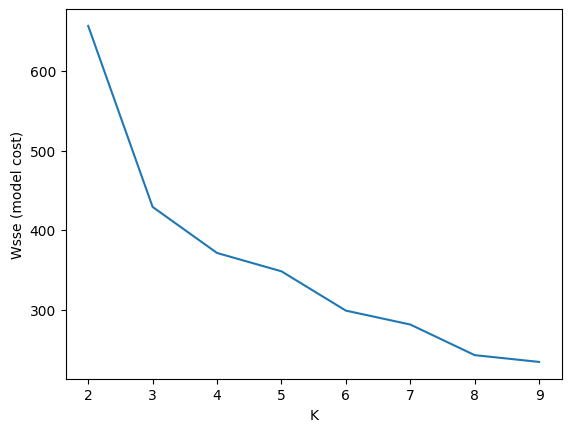

In [22]:
fig, ax = plt.subplots()
ax.set_xlabel('K')
ax.set_ylabel('Wsse (model cost)')
x, y = zip(*wsse_by_k)

ax.plot(x, y)